# Fraud Detection with Ensemble Models  

This notebook focusing on fraud detection in highly imbalanced data.  
I experimented with multiple models — Logistic Regression, Isolation Forest, a Neural Network and  a ensemble and evaluate them individually.

In [1]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_parquet("/content/train.parquet")
test = pd.read_parquet("/content/test.parquet")

# **Data Overview**

In [4]:
print(train.shape, test.shape)

(1639424, 7) (409856, 7)


In [5]:
train.head()

,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


In [6]:
train.describe()

,Date,X1,X2,X3,X4,X5
count,1639424,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06
mean,2022-12-03 07:23:43.817145600,1.139258e+00,5.488189e+00,4.110388e+32,2.706323e+29,1.187219e+00
min,2020-12-16 00:00:00,1.000000e+00,5.412539e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,2021-12-10 00:00:00,1.049171e+00,5.480597e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,2022-11-30 00:00:00,1.105171e+00,5.488979e+00,1.000000e+00,1.000000e+00,6.931472e-01
75%,2023-11-23 00:00:00,1.214096e+00,5.496717e+00,1.000000e+00,2.718282e+00,2.890372e+00
max,2024-12-11 00:00:00,4.014850e+00,5.541852e+00,1.651636e+38,5.540622e+34,3.465736e+00
std,NaN,1.391992e-01,1.342811e-02,2.346156e+35,5.812988e+31,1.304814e+00


In [7]:
test.describe()

,ID,Date,X1,X2,X3,X4,X5
count,409856.000000,409856,409856.000000,409856.000000,4.098560e+05,4.098560e+05,409856.000000
mean,204927.500000,2022-12-03 08:15:48.485321216,1.139317,5.488174,1.544527e+32,4.857705e+29,1.190927
min,0.000000,2020-12-16 00:00:00,1.000000,5.415434,1.000000e+00,1.000000e+00,0.000000
25%,102463.750000,2021-12-10 00:00:00,1.049171,5.480556,1.000000e+00,1.000000e+00,0.000000
50%,204927.500000,2022-11-30 00:00:00,1.105171,5.488979,1.000000e+00,1.000000e+00,0.693147
75%,307391.250000,2023-11-23 00:00:00,1.214096,5.496717,1.000000e+00,2.718282e+00,2.890372
max,409855.000000,2024-12-11 00:00:00,3.455613,5.539890,6.076030e+37,5.540622e+34,3.465736
std,118315.380301,NaN,0.138936,0.013439,9.494028e+34,1.036758e+32,1.305848


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB


In [9]:
train['target'].value_counts(normalize="True")

,proportion
target,
0,0.991437
1,0.008563


# **EDA**

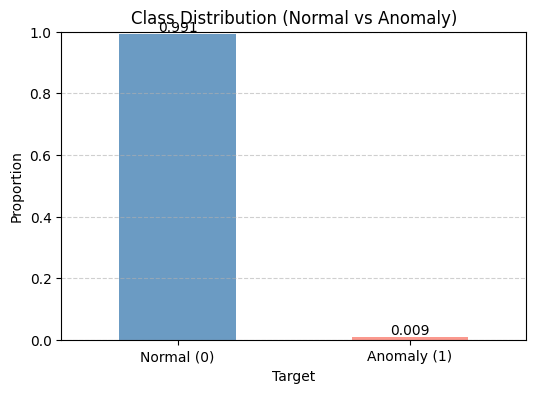

In [10]:
import matplotlib.pyplot as plt

class_counts = train['target'].value_counts(normalize=True)

plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['steelblue', 'salmon'], alpha=0.8)

plt.title("Class Distribution (Normal vs Anomaly)")
plt.xticks([0,1], ['Normal (0)', 'Anomaly (1)'], rotation=0)
plt.ylabel("Proportion")
plt.xlabel("Target")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)

plt.show()

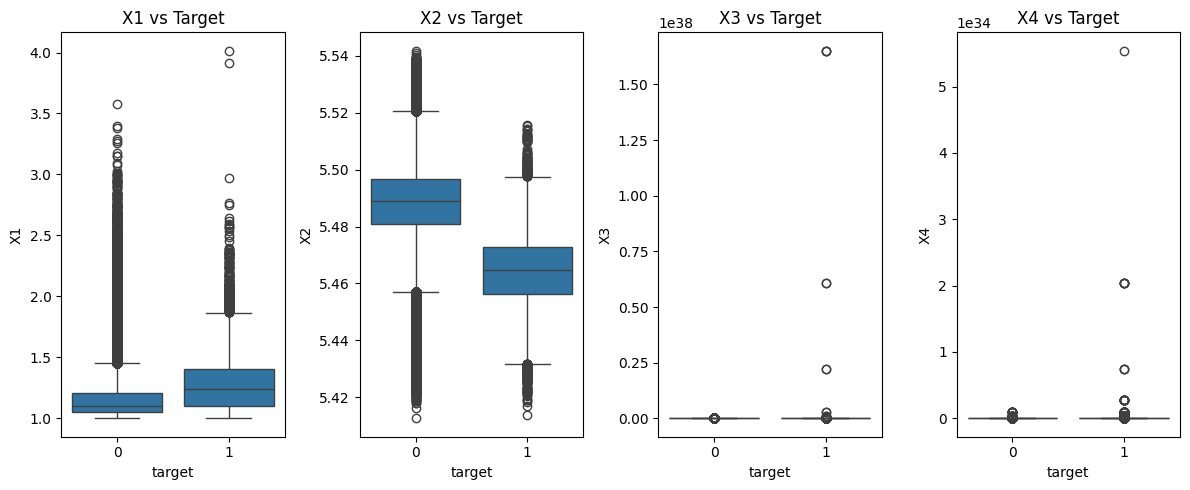

In [11]:
import seaborn as sns

plt.figure(figsize=(12, 5))
for i, col in enumerate(['X1','X2', 'X3', 'X4'], 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=train, x='target', y=col)
    plt.title(f'{col} vs Target')
plt.tight_layout()
plt.show()

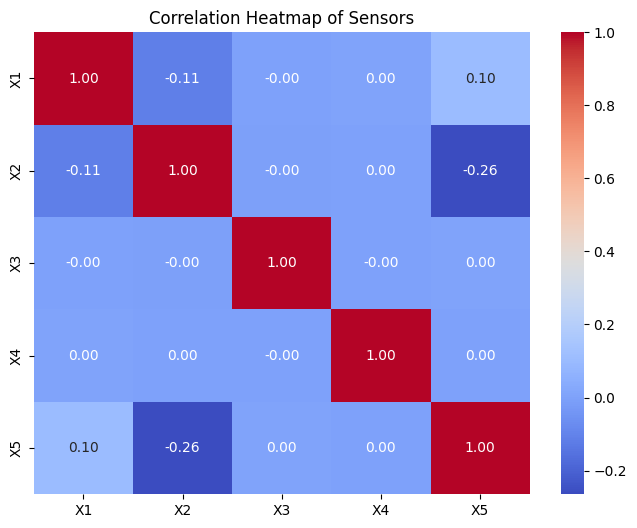

In [12]:
plt.figure(figsize=(8, 6))
corr = train[['X1','X2','X3','X4','X5']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Sensors')
plt.show()

#  **Modeling**

**Setup**

In [13]:
!pip install xgboost catboost --quiet
!pip install --upgrade xgboost

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 42

def best_threshold(y_true, y_prob, grid=np.linspace(0.01, 0.99, 99)):
    """Finds threshold that maximizes F1 on validation/OoF probabilities."""
    best_t, best_f1 = 0.5, -1
    for t in grid:
        f1 = f1_score(y_true, (y_prob >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

def print_scores(y_true, y_pred, name=""):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"{name}  F1={f1:.6f}  Acc={acc:.6f}")
    return f1, acc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


**Feature Extraction**

In [14]:
for df in (train, test):
    df["year"]  = df["Date"].dt.year
    df["month"] = df["Date"].dt.month
    df["day"]   = df["Date"].dt.day
    df["dow"]   = df["Date"].dt.dayofweek
    df["doy"]   = df["Date"].dt.dayofyear

    df.drop(columns=["Date"], inplace=True)

TARGET = "target"
ID_COL = "ID" if "ID" in test.columns else None

features = [c for c in train.columns if c not in [TARGET, ID_COL] and train[c].dtype != "O"]

X = train[features].copy()
y = train[TARGET].astype(int).copy()
X_test = test[features].copy()


In [15]:
# stratified folds for imbalance
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

# imbalance ratio for boosting
pos_ratio = (y == 1).mean()
scale_pos_weight = (1 - pos_ratio) / max(pos_ratio, 1e-8)
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 115.78472716911241


**XGBoost Training**

In [17]:
import xgboost as xgb
oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (tr, va) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_va, label=y_va)
    dtest  = xgb.DMatrix(X_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "learning_rate": 0.03,
        "max_depth": 6,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "scale_pos_weight": scale_pos_weight,
        "seed": RANDOM_STATE,
        "tree_method": "hist"
    }

    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=50,
        verbose_eval=50
    )

    oof_xgb[va] = booster.predict(dvalid)
    test_xgb += booster.predict(dtest) / n_splits

thr, f1b = best_threshold(y, oof_xgb)
print(f"[XGB] best OoF threshold={thr:.3f}, F1={f1b:.6f}")



[0]	valid-aucpr:0.58611
[50]	valid-aucpr:0.66961
[100]	valid-aucpr:0.69705
[150]	valid-aucpr:0.72670
[200]	valid-aucpr:0.74345
[250]	valid-aucpr:0.75543
[300]	valid-aucpr:0.76337
[350]	valid-aucpr:0.76970
[400]	valid-aucpr:0.77562
[450]	valid-aucpr:0.78130
[500]	valid-aucpr:0.78611
[550]	valid-aucpr:0.79069
[600]	valid-aucpr:0.79377
[650]	valid-aucpr:0.79685
[700]	valid-aucpr:0.79975
[750]	valid-aucpr:0.80297
[800]	valid-aucpr:0.80582
[850]	valid-aucpr:0.80819
[900]	valid-aucpr:0.81112
[950]	valid-aucpr:0.81308
[999]	valid-aucpr:0.81515
[0]	valid-aucpr:0.61683
[50]	valid-aucpr:0.68069
[100]	valid-aucpr:0.70348
[150]	valid-aucpr:0.73328
[200]	valid-aucpr:0.75349
[250]	valid-aucpr:0.76534
[300]	valid-aucpr:0.77281
[350]	valid-aucpr:0.77999
[400]	valid-aucpr:0.78524
[450]	valid-aucpr:0.78978
[500]	valid-aucpr:0.79374
[550]	valid-aucpr:0.79804
[600]	valid-aucpr:0.80188
[650]	valid-aucpr:0.80501
[700]	valid-aucpr:0.80760
[750]	valid-aucpr:0.81068
[800]	valid-aucpr:0.81273
[850]	valid-aucpr:

**CatBoost Training**

In [18]:
oof_cat = np.zeros(len(X))
test_cat = np.zeros(len(X_test))

for fold, (tr, va) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    cat = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3.0,
        loss_function="Logloss",
        eval_metric="AUC:use_weights=false",
        random_seed=RANDOM_STATE,
        auto_class_weights="Balanced",
        task_type="CPU",
        od_type="Iter",5
        od_wait=100,
        verbose=200
    )

    cat.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True)

    oof_cat[va] = cat.predict_proba(X_va)[:, 1]
    test_cat += cat.predict_proba(X_test)[:, 1] / n_splits

thr, f1b = best_threshold(y, oof_cat)
print(f"[CAT] best OoF threshold={thr:.3f}, F1={f1b:.6f}")
print_scores(y, (oof_cat >= thr).astype(int), "[CAT OoF]")


0:	test: 0.9776671	best: 0.9776671 (0)	total: 734ms	remaining: 24m 27s
200:	test: 0.9901234	best: 0.9901234 (200)	total: 1m 7s	remaining: 10m 7s
400:	test: 0.9914730	best: 0.9914730 (400)	total: 2m 13s	remaining: 8m 51s
600:	test: 0.9920537	best: 0.9920556 (599)	total: 3m 17s	remaining: 7m 40s
800:	test: 0.9923767	best: 0.9923767 (800)	total: 4m 22s	remaining: 6m 33s
1000:	test: 0.9925573	best: 0.9925573 (1000)	total: 5m 28s	remaining: 5m 27s
1200:	test: 0.9925979	best: 0.9926257 (1158)	total: 6m 33s	remaining: 4m 21s
1400:	test: 0.9926992	best: 0.9927034 (1393)	total: 7m 38s	remaining: 3m 16s
1600:	test: 0.9928016	best: 0.9928066 (1556)	total: 8m 43s	remaining: 2m 10s
1800:	test: 0.9928874	best: 0.9929078 (1751)	total: 9m 48s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9929077524
bestIteration = 1751

Shrink model to first 1752 iterations.
0:	test: 0.9797705	best: 0.9797705 (0)	total: 298ms	remaining: 9m 56s
200:	test: 0.9909583	best: 0.990958

(0.7335487661574618, 0.9955740552779513)

**Blend XGB + CatBoost**

In [19]:
oof_blend = 0.5 * oof_xgb + 0.5 * oof_cat   # try other weights like 0.6/0.4
test_blend = 0.5 * test_xgb + 0.5 * test_cat

thr, f1b = best_threshold(y, oof_blend)
print(f"[Blend] best OoF threshold={thr:.3f}, F1={f1b:.6f}")

print_scores(y, (oof_blend >= thr).astype(int), "[Blend OoF]")

preds_blend = (test_blend >= thr).astype(int)

# Save for submission
sub = pd.DataFrame({
    "ID": test['ID'],      # replace with your test ID column
    "target": preds_blend
})
sub.to_csv("blend_submission.csv", index=False)

print("Submission file saved as blend_submission.csv")


[Blend] best OoF threshold=0.960, F1=0.744578
[Blend OoF]  F1=0.744578  Acc=0.995654
Submission file saved as blend_submission.csv


**Logistic Regression baseline**

In [20]:
oof_lr = np.zeros(len(X))
test_lr = np.zeros(len(X_test))

for fold, (tr, va) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    # scale numeric features for LR
    lr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=None,
            solver="lbfgs"
        ))
    ])

    lr_pipe.fit(X_tr, y_tr)
    oof_lr[va] = lr_pipe.predict_proba(X_va)[:, 1]
    test_lr += lr_pipe.predict_proba(X_test)[:, 1] / n_splits

thr, f1b = best_threshold(y, oof_lr)
print(f"[LR ] best OoF threshold={thr:.3f}, F1={f1b:.6f}")
print_scores(y, (oof_lr >= thr).astype(int), "[LR OoF]")

[LR ] best OoF threshold=0.970, F1=0.309016
[LR OoF]  F1=0.309016  Acc=0.988486


(0.30901570335663825, 0.9884855900608994)

**Weighted average ensemble**

In [21]:
weights = np.arange(0.0, 1.01, 0.1)
best = {"f1": -1, "w": (1/3,1/3,1/3), "thr": 0.5}

for wx in weights:
    for wc in weights:
        wl = 1.0 - wx - wc
        if wl < 0 or wl > 1:
            continue
        oof_ens = wx*oof_xgb + wc*oof_cat + wl*oof_lr
        thr, f1b = best_threshold(y, oof_ens)
        if f1b > best["f1"]:
            best = {"f1": f1b, "w": (wx,wc,wl), "thr": thr}

wx, wc, wl = best["w"]
thr_ens = best["thr"]
print(f"[W-AVG] best weights xgb={wx:.2f}, cat={wc:.2f}, lr={wl:.2f} | thr={thr_ens:.3f} | OoF F1={best['f1']:.6f}")

# Final OoF scores for the chosen weights
oof_wavg = wx*oof_xgb + wc*oof_cat + wl*oof_lr
print_scores(y, (oof_wavg >= thr_ens).astype(int), "[W-AVG OoF]")

# Apply to test
test_wavg = wx*test_xgb + wc*test_cat + wl*test_lr
pred_wavg = (test_wavg >= thr_ens).astype(int)


[W-AVG] best weights xgb=0.50, cat=0.50, lr=0.00 | thr=0.960 | OoF F1=0.744578
[W-AVG OoF]  F1=0.744578  Acc=0.995654


**Stacking ensemble**

In [22]:
X_meta_oof = np.vstack([oof_xgb, oof_cat, oof_lr]).T
X_meta_test = np.vstack([test_xgb, test_cat, test_lr]).T

# Meta model: logistic regression
meta = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
meta.fit(X_meta_oof, y)

oof_meta = meta.predict_proba(X_meta_oof)[:, 1]
thr_meta, f1_meta = best_threshold(y, oof_meta)
print(f"[STACK] best OoF threshold={thr_meta:.3f}, F1={f1_meta:.6f}")
print_scores(y, (oof_meta >= thr_meta).astype(int), "[STACK OoF]")

test_meta = meta.predict_proba(X_meta_test)[:, 1]
pred_stack = (test_meta >= thr_meta).astype(int)


[STACK] best OoF threshold=0.990, F1=0.679577
[STACK OoF]  F1=0.679577  Acc=0.994863


**Final  Submission**

In [23]:
# Choose the better one on OoF: weighted-average vs stacking
use_stack = f1_meta >= best["f1"]

if use_stack:
    final_prob = test_meta
    final_thr  = thr_meta
    final_pred = pred_stack
    print(">> Using STACKING for submission.")
else:
    final_prob = test_wavg
    final_thr  = thr_ens
    final_pred = pred_wavg
    print(">> Using WEIGHTED-AVERAGE for submission.")

# class balance of predictions
print("Positive rate in test preds:", final_pred.mean())

# Build submission
sub = pd.DataFrame({
    (ID_COL if ID_COL else "ID"): test[ID_COL] if ID_COL else np.arange(len(test)),
    "prediction": final_pred
})
sub["probability"] = final_prob

sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


>> Using WEIGHTED-AVERAGE for submission.
Positive rate in test preds: 0.008417590568394754
Saved submission.csv
